# "TimeHistory_Analysis"
### A Tool for *Modeling* & *TimeHistory Analysis*
### of *Rectangular 2D Frames* with *Lumped Mass Method*
#####   
## Assumptions:
 - Frame is Massless
 - Lumped-Mass comes from  the distributed dead load on the Beams
 
 ##### 
 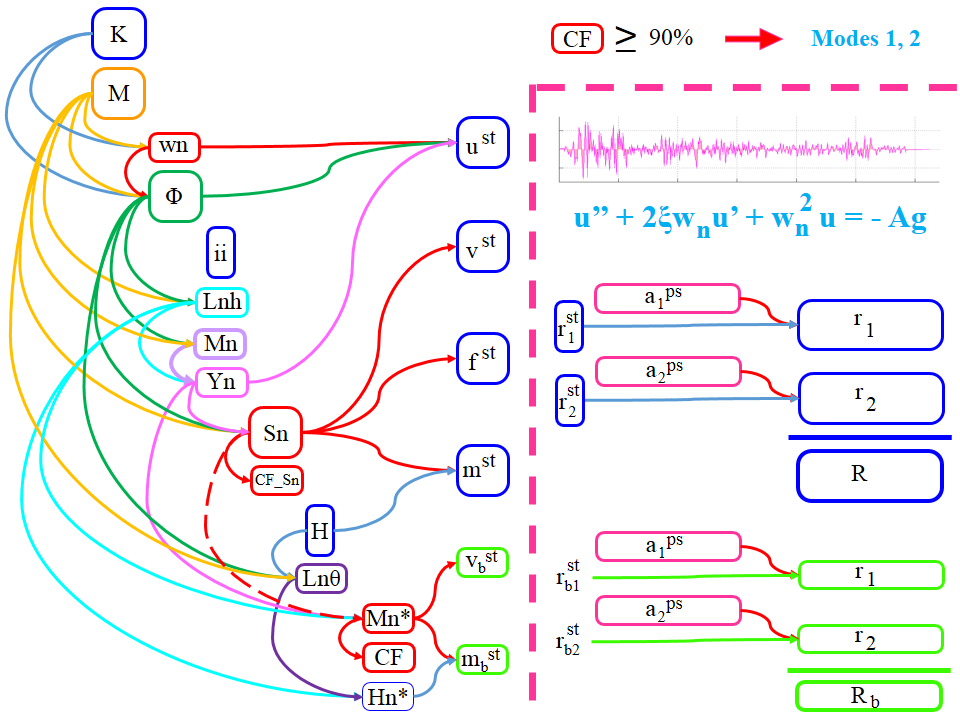

In [1]:
# (auto) importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
import copy


##### 
### Structure Data (input)

In [2]:
# (input)
 
nStory      = 20                             # number of stories

hStory_typ  = 3200                           # height of typical stories
hStory_Base = 4000                           # height of base_floor                         

wBay = [ 4000, 3200, 4500 ]                  # width of bays

Braced_Bays    = [ 2 ]                       # Doubly (X) Braced  Bays              
Braced_Stories = [ 7, 14 ]                   # Doubly (X) Braced Storys 

# sections:
# All Columns:    IPBv 220:  A=14900 (mm2)    I=146.0*10**6 (mm4) 
# All Beams:      IPE  300:  A= 5380 (mm2)    I= 83.6*10**6 (mm4) 
# All Diagonals:  UPE  120:  A= 1700 (mm2)   

E_Cols, E_Beams, E_Diags = 200,200,200       # Modulus of Elasticity (KN/mm2)
A_Cols, A_Beams, A_Diags = 14900,5380,1700   # Area (mm2)  
I_Cols, I_Beams          = 146e6,83.6e6      # Moment of Inertia (mm4)
  
W_Beams = 0.02                               # rectangular Distributed Load on Beams (KN/mm)
                                             # towards Ground is +ve


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                                                                                               #
#                                         D y n a m i c                                         #
#                                                                                               #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

rD = 0.02                   # Damping Ratio for all Modes
g  = 9.8e3                  # ( mm/sec2 )
Modal_Contribution = 0.90   # usually 0.85


##### 
### Structure Data (auto)  

In [3]:
# (auto) Checking & completing

hStory    = np.ones( (nStory,1) ) * hStory_typ     
hStory[0] = hStory_Base 

# Height, H
H = list( hStory[0] )
for i in range(1,nStory):
    a = hStory[i][0] 
    b = H[-1]
    H.append ( a+b )

nBay = len(wBay)    # number of bays

Braced_Bays = sorted( Braced_Bays )
keep = []
for i in Braced_Bays:
    if i <= nBay: keep.append(i)
    else: print('\n Warning!',
                '\n Bay', i, "does not exist thus can't be braced.", 
                i, 'is removed from Braced_Bays' )
Braced_Bays = sorted(keep)  

Braced_Stories = sorted( Braced_Stories )
keep = []
for i in Braced_Stories:
    if i <= nStory: keep.append(i)
    else: print('\n Warning!',
                '\n Story', i, "does not exist thus can't be braced.", 
                i, 'is removed from Braced_Stories' )
Braced_Stories = sorted(keep) 

#####   
### Points & Connectivity Matrices

In [4]:
# (auto) Making Frame & Checking Shape

# defining a function called PC 
# to calculate Points & Connectivity matrices of Columns, beams and diagonals 

def PC( wBay, hStory, Braced_Bays, Braced_Stories ): 
    
    Xwalk = [0]
    for i in wBay:
        w = Xwalk[-1] + i
        Xwalk.append(w)
    Ywalk = [0]
    for i in hStory: 
        h = Ywalk[-1] + i
        Ywalk.append(h) 
    X=len(Xwalk)
    Y=len(Ywalk) 
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y):
        for i in range(0,X):
            x.append( int(Xwalk[i]) )
            y.append( int(Ywalk[j]) )
            index.append(idx)
            idx = idx+1
    Dict = {  'x': x
            , 'y': y  }
    Points = pd.DataFrame( data=Dict, index=index ) 
    
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y-1): 
        for i in range(0,X): 
            x.append( int(i+j*X)   )
            y.append( int(i+j*X+X) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y }
    CnC = pd.DataFrame( data=Dict, index=index )
    
    x,y, index = [],[],[]
    idx=0
    for j in range(1,Y):
        for i in range(0,X-1): 
            p0 = i + j*X
            p1 = p0 + 1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y
           }
    CnB = pd.DataFrame( data=Dict, index=index ) 
    
    x,y, index, D_story = [],[],[],[]
    idx=0
    for b in Braced_Bays:
        for j in range(0,Y-1): 
            
            D_story.append(int(j+1))
            p0 = b-1 + j*X
            p1 = p0 + X+1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
            
            D_story.append(int(j+1))
            p0 = b + j*X
            p1 = p0 + X-1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
            
    Dict = {  'from_point': x
            , 'to_point': y }
    CnD_Bays = pd.DataFrame( data=Dict, index=index )

    x,y, index = [],[],[]
    idx=0
    for b in Braced_Stories:
        for i in range(0,X-1):
            
            D_story.append(int(b))
            p0 = (b-1)*X + i
            p1 = p0 + X+1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
            
            D_story.append(int(b))
            p0 = (b-1)*X + i+1
            p1 = p0 + X-1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
            
    Dict = {  'from_point': x
            , 'to_point': y } 
    CnD_Stories = pd.DataFrame( data=Dict, index=index )
    CnD = pd.concat([CnD_Bays,CnD_Stories],axis=0)
    CnD.index = range(0,len(CnD))
    
    Dict = {  'Story': D_story
            , 'Dummy': D_story } 
    D_Story = pd.DataFrame( data=Dict, index=range(0,len(D_story)) )      
    
    # finding & removing duplicates in CnD & D_story
    Dup=[] 
    for i in range(0,len(CnD)):
        for j in range(i+1,len(CnD)):
            if CnD.iloc[i,0]==CnD.iloc[j,0]:
                if CnD.iloc[i,1]==CnD.iloc[j,1]:
                    Dup.append(j)
                    
    CnD = CnD.drop(Dup)
    CnD.index = range(0,len(CnD)) 
    CnD = CnD.astype(int)
     
    D_Story = D_Story.drop(Dup)
    D_Story.index = range(0,len(D_Story)) 
    D_Story = D_Story.astype(int)
    
    
    return [ Points, CnC, CnB, CnD, D_Story ]

[ Points, CnC, CnB, CnD, D_Story ] = PC( wBay, hStory, Braced_Bays, Braced_Stories ) 

##### 
### Plotting Structure Shape

C:\Users\EZ-Tech\AppData\Local\Temp\ipykernel_1228\2439421063.py:72: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  ytks = np.array(Ywalk,dtype='f8')


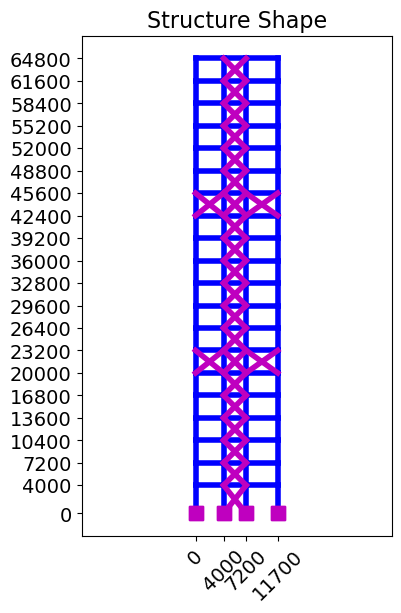

In [5]:
# define a function called Shape
# to check shape of frame

def  Shape( Points, CnC, CnB, CnD, wBay, hStory ):
    
    fig, ax = plt.subplots( figsize=(4,6.5) )
    
    for i in CnC.index: 
        i0 = CnC.loc[i,'from_point']
        i1 = CnC.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( #marker='o', markersize=15, mec='m', mew=1, mfc='m',
                 x, y, lw=4, c='b', ls='-' )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( #marker='o', markersize=15, mec='m', mew=1, mfc='m',
                 x, y, lw=4, c='b', ls='-' )
        
    for i in CnD.index: 
        i0 = CnD.loc[i,'from_point']
        i1 = CnD.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( #marker='o', markersize=15, mec='m', mew=1, mfc='m',
                 x, y, lw=4, c='m', ls='-' )

    GroundPoints = Points[ Points.loc[:,'y']==0 ]  
    for i in GroundPoints.index:  
        x0 = GroundPoints.loc[i,'x']
        x1 = GroundPoints.loc[i,'x']
        y0 = GroundPoints.loc[i,'y']
        y1 = GroundPoints.loc[i,'y'] 
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=5, c='m', ls='-'
                , marker='s', markersize=10, mec='m', mew=1, mfc='m')   
        
    # title
    plt.title( 'Structure Shape', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(rotation=45,fontsize=14) 
                  
    # yticks
    Ywalk = [0]
    for i in hStory: 
        h = Ywalk[-1] + i 
        Ywalk.append(h)
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(rotation=0,fontsize=14)
    
    ax.axis('equal')
    plt.savefig('Check_Shape.png', dpi=120) 
    plt.show()
        
Shape( Points, CnC, CnB, CnD, wBay, hStory )

#####   
### Finding Static Coefficients

In [6]:
# (auto) Coefficients
# define a function called Static_Coeff 
# to find Static Analysis Coefficients: 
#
#   NOP:    Number Of Points
#   NOD:    Number of "Degrees of freedom"
#   RD:     Restrained "Degrees of freedom"
#   FD:     Free "Degrees of freedom"
#   NFD:    Number of Free "Degrees of Freedom"
#   NC:     Number of Columns
#   NB:     Number of Beams
#   ND:     Number of Diagonals(braces)
#   IndxC:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all columns
#   IndxB:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all beams
#   IndxD:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all diagonals (braces)
 
def Static_Coeff( Points, CnC, CnB, CnD, wBay ):
    
    # NOP NOD RD FD NFD
    NOP=Points.shape[0]; NOD=NOP*3;
    X=len(wBay)+1; RD=sorted(list(range(0,3*X))); NRD=len(RD)
    FD=range(NRD,NOD); NFD=len(FD)
    
    # NX
    NC, NB, ND = CnC.shape[0],  CnB.shape[0],  CnD.shape[0]
    
    # IndxC
    c0,c1,c2, c3,c4,c5 = [],[],[], [],[],[]
    index, idx = [], 0  
    for i in range( 0, NC ):
        c0.append( 3*CnC.iloc[i,0]+0 )
        c1.append( 3*CnC.iloc[i,0]+1 )
        c2.append( 3*CnC.iloc[i,0]+2 )
        c3.append( 3*CnC.iloc[i,1]+0 )
        c4.append( 3*CnC.iloc[i,1]+1 )
        c5.append( 3*CnC.iloc[i,1]+2 )
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  ,  'near_z' : c2
            , 'far_x' :c3  ,  'far_y' :c4  ,  'far_z'  : c5
        }
    IndxC = pd.DataFrame( data=Dict, index=index )
    
    # IndxB
    c0,c1,c2, c3,c4,c5 = [],[],[], [],[],[]
    index, idx = [], 0  
    for i in range( 0, NB ):
        c0.append( 3*CnB.iloc[i,0]+0 )
        c1.append( 3*CnB.iloc[i,0]+1 )
        c2.append( 3*CnB.iloc[i,0]+2 )
        c3.append( 3*CnB.iloc[i,1]+0 )
        c4.append( 3*CnB.iloc[i,1]+1 )
        c5.append( 3*CnB.iloc[i,1]+2 )
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  ,  'near_z' : c2
            , 'far_x' :c3  ,  'far_y' :c4  ,  'far_z'  : c5
        }
    IndxB = pd.DataFrame( data=Dict, index=index )    
    
    # IndxD
    c0,c1,    c3,c4 = [],[],    [],[] 
    index, idx = [], 0  
    for i in range( 0, ND ):
        c0.append( 3*CnD.iloc[i,0]+0 )
        c1.append( 3*CnD.iloc[i,0]+1 ) 
        c3.append( 3*CnD.iloc[i,1]+0 )
        c4.append( 3*CnD.iloc[i,1]+1 ) 
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  
            , 'far_x' :c3  ,  'far_y' :c4  
        }
    IndxD = pd.DataFrame( data=Dict, index=index )
    
    return [NOP, NOD, RD, FD, NFD, NC, NB, ND, IndxC, IndxB, IndxD]


[NOP, NOD, RD, FD, NFD, NC, NB, ND, IndxC, IndxB, IndxD] = Static_Coeff( Points, CnC, CnB, CnD, wBay )


#####   
### Assigning

In [7]:
# (auto) define a function called Elements
# to asign material & shape Properties & distributed load 
# to columns, beams and trusses

def Elements( 
      NB, IndxB, E_Beams, A_Beams, I_Beams, W_Beams
    , NC, IndxC, E_Cols,  A_Cols,  I_Cols
    , ND, IndxD, E_Diags, A_Diags,          D_Story ):
    
    EC = np.ones( [NC,1],'f4' ) * E_Cols
    AC = np.ones( [NC,1],'f4' ) * A_Cols
    IC = np.ones( [NC,1],'f4' ) * I_Cols
    
    EB = np.ones( [NB,1],'f4' ) * E_Beams
    AB = np.ones( [NB,1],'f4' ) * A_Beams
    IB = np.ones( [NB,1],'f4' ) * I_Beams
    WB = np.ones( [NB,1],'f4' ) * W_Beams
    
    ED = np.ones( [ND,1],'f4' ) * E_Diags
    AD = np.ones( [ND,1],'f4' ) * A_Diags
    
    Beams     = IndxB[ ['far_x','far_y'] ].copy();   
    Columns   = IndxC[ ['far_x','far_y'] ].copy();   
    Diagonals = IndxD[ ['far_x','far_y'] ].copy();
    
    Beams['E'] = EB;      Columns['E'] = EC;      Diagonals['E'] = ED;
    Beams['A'] = AB;      Columns['A'] = AC;      Diagonals['A'] = AD;
    Beams['I'] = IB;      Columns['I'] = IC;
    Beams['W'] = WB;                              Diagonals['Story']=D_Story['Story'].copy();
    
    Beams = Beams.drop(['far_x','far_y'],axis=1)
    Columns = Columns.drop(['far_x','far_y'],axis=1)
    Diagonals = Diagonals.drop(['far_x','far_y'],axis=1)
    
    return [Beams, Columns, Diagonals]


# assigning properties & load to elements
[ Beams, Columns, Diagonals ] = Elements( NB, IndxB, E_Beams, A_Beams, I_Beams, W_Beams
                                        , NC, IndxC, E_Cols,  A_Cols,  I_Cols
                                        , ND, IndxD, E_Diags, A_Diags,          D_Story  )

#####   
### Length of Elements

In [8]:
# (auto) defining a function called Add_Length
# to add Length, L, to Emements DataFrames 

def Add_Length(  Points
             , CnC, NC, Columns
             , CnB, NB, Beams 
             , CnD, ND, Diagonals ):
    
    # Assigning Properties 
    LC, LB, LD, cD  =  [],[],[],[]   
    
    for i in range(0,NC): 
        dx = Points.iloc[CnC.iloc[i,1],0]-Points.iloc[CnC.iloc[i,0],0]
        dy = Points.iloc[CnC.iloc[i,1],1]-Points.iloc[CnC.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LC.append(L)
        
    for i in range(0,NB): 
        dx = Points.iloc[CnB.iloc[i,1],0]-Points.iloc[CnB.iloc[i,0],0]
        dy = Points.iloc[CnB.iloc[i,1],1]-Points.iloc[CnB.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LB.append(L)
        
    for i in range(0,ND): 
        dx = Points.iloc[CnD.iloc[i,1],0]-Points.iloc[CnD.iloc[i,0],0]
        dy = Points.iloc[CnD.iloc[i,1],1]-Points.iloc[CnD.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LD.append(L)
        c = dx/L;                    cD.append( c )
        
    Columns['L']   = LC
    Beams['L']     = LB
    Diagonals['L'] = LD
    Diagonals['L'] = round( Diagonals['L'],-1 )
    Diagonals['cosTeta'] = cD
    Diagonals['cosTeta'] = round( Diagonals['cosTeta'],3 )
  
    return [ Columns, Beams, Diagonals ]

# Adding L to Elements
[ Columns, Beams, Diagonals ] = Add_Length( Points
                                          , CnC, NC, Columns
                                          , CnB, NB, Beams 
                                          , CnD, ND, Diagonals )

##### 
### Dynamic Stiffness & Mass: Kdyn & Mdyn

In [9]:
# (auto) define a function caaled KdynMdyn
# to return Kdyn & Mdyn

def KdynMdyn( Columns, Beams, Diagonals, nStory, hStory, nBay, g ): 
    
    Degrees = np.arange( 0, nStory+1 )
    
    Kdyn = np.zeros([ nStory+1, nStory+1 ], 'float64' )
    Kdyn = pd.DataFrame( Kdyn, columns=range(nStory+1) )
    Kdyn.index = Kdyn.columns
    
    Cols = Columns.copy()
    Cols['k'] = 12 * Cols['E'] * Cols['I'] / Cols['L']**3 
    
    Diags = Diagonals.copy()
    Diags['k'] = ( Diags['E'] * Diags['A'] / Diags['L'] ) * Diags['cosTeta']**2
    
    # columns
    X = nBay+1
    Kcol = []
    for i in range(0,nStory):
        s=0
        for j in range(0,X):
            s = s + Cols.loc[i*X+j,'k']
        Kcol.append(s)   
         
            
    # Diagonals 
    ND = Diags.shape[0]
    Kdiag =  np.zeros([ND,1],'float64') 
    for i in range(0,ND):
        story = Diags.loc[i,'Story']
        Kdiag[story-1] = Kdiag[story-1] + Diags.loc[i,'k'] * 0.5    # Just Diagonals in tension
    
    # assembly
    for i in range(0,nStory): 
        s = Kcol[i]  +  Kdiag[i][0]
        s = np.array( [[s, -s], [-s, s]], 'float64' )
        idx = [i,i+1]
        Kdyn.iloc[idx,idx] = Kdyn.iloc[idx,idx] + s
        
    Kdyn = Kdyn.iloc[range(1,nStory+1),range(1,nStory+1)]    
    
    M = []
    for i in range(0,nStory):
        m = 0
        for j in range(0,nBay):
            b = i*nBay+j
            m = m + Beams.loc[b,'W']*Beams.loc[b,'L']                      
        M.append(m/g)
        
    Mdyn = np.diag(M)     
    Mdyn = pd.DataFrame( Mdyn, columns=range(1,nStory+1) )
    Mdyn.index = Mdyn.columns
    
    return [Kdyn, Mdyn]


[ Kdyn, Mdyn ] = KdynMdyn( Columns, Beams, Diagonals, nStory, hStory, nBay, g )

#####  
### Natural Frequencies & Mode-Shapes

In [10]:
# (auto) define a function called Modal
# to perform the modal analysis 
#    Note:  Number of Modes = Number of Stories

def Modal( Kyn, Mdyn ):
    
    from scipy import linalg 
    nStory = Mdyn.shape[0]
    
    w2, fi = linalg.eig(Kdyn,Mdyn)
    
    fi = pd.DataFrame( fi, columns = np.round(np.abs(w2),1).astype(float) )  
    fi = fi.sort_index(axis=1)          
    fi = fi.iloc[:,range(0,nStory)]       # Note:  number of Modes = nStory
    
    for j in range(0,nStory):
        Coeff = sum(np.diag(Mdyn)*fi.iloc[:,j]**2) ** 0.5 
        fi.iloc[:,j] = fi.iloc[:,j] / Coeff 
    
    fi.columns = range(1,nStory+1)
    fi.index   = fi.columns
    
    # CheckPoint1_a      fi.T @ Mdyn @ fi  = Unity ?  
    CheckPoint1_a = sum(sum( (fi.T@Mdyn@fi).values-np.eye(nStory) ))
    print( '\nCheckPoint1_a:   0.0 =', CheckPoint1_a )
    
    wn = np.array( sorted( np.abs(w2) ** .5 ), 'float64' )
    fn = wn  / (2*np.pi)
    Tn = 1.0 / fn
    
    Dict  = { 'wn':wn, 'fn':fn, 'Tn':Tn }
    wfT_n = pd.DataFrame( data=Dict, columns=['wn','fn','Tn'] ) 
    wfT_n.index = range(1,nStory+1)
    
    # CheckPoint1_b      fi.T @ Kdyn @ fi  = wn**2 ? 
    CheckPoint1_b = sum(sum( (fi.T@Kdyn@fi).values-np.diag(wfT_n['wn']**2) ))
    print( '\nCheckPoint1_b:   0.0 =', CheckPoint1_b )
    
    # Mode_Shapes  (Decorated Version of fi)
    cols,Indx = [],[]
    for i in range(1,nStory+1):
        cols.append('Mode_'+str(i))
        Indx.append('Story_'+str(i))
    Mode_Shapes = pd.DataFrame( data=fi.values, columns=cols, index=Indx )
        
    
    return [ wfT_n, fi, Mode_Shapes ] 
 
    
[ wfT, fi, Mode_Shapes ] = Modal( Kdyn, Mdyn )  
wfT.head(3)


CheckPoint1_a:   0.0 = 5.490518369667947e-13

CheckPoint1_b:   0.0 = 9.475300451807639e-09


,wn,fn,Tn
1,4.404840,0.701052,1.426428
2,13.204697,2.101593,0.475830
3,21.959677,3.494991,0.286124


##### 
### Plotting Mode Shapes

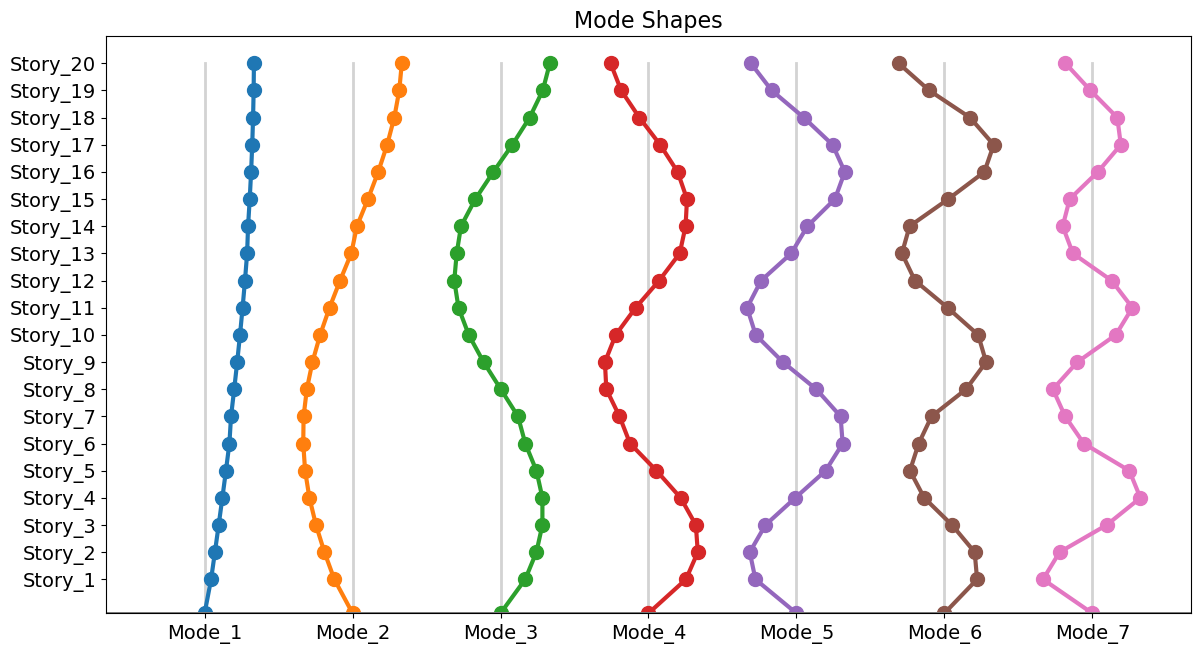

In [11]:
# (input)
# Desired Modes To Be Plotted
Modes = [ 1, 2, 3, 4, 5, 6, 7 ] 

# (auto)
# define a function called plot_modes to plot the desired modes

def plot_modes(Modes,fi,nStory,H): 
    
    m=list(set(sorted(Modes)));  Modes=[]
    for i in range(0,len(m)): 
        if m[i] <= nStory: Modes.append(m[i])
    
    n = len(Modes)
    
    x = [2000]
    for i in range(1,n): x.append( x[-1]+3000 ) 

    fi_plot = fi.copy()
    for j in range(0,fi.shape[1]):
        Max = np.max(np.abs(fi_plot.iloc[:,j])) 
        fi_plot.iloc[:,j] = fi_plot.iloc[:,j] / Max *1000
    
    x_Modes = np.zeros([nStory,n],'float64')
    for i in range(0,n):
        x_Modes[:,i] = x[i] + fi_plot.iloc[ :, Modes[i]-1 ]  
    
    Points = pd.DataFrame(x_Modes,columns=Modes)
    Points['Y'] = H


    fig, ax = plt.subplots( figsize=(14,7.5) )
    for i in range(0,n):
        mode = Modes[i]
        X,Y = [x[i]],[0]  
        for Points_x in Points[mode]: X.append(Points_x)
        for Points_y in Points['Y']:  Y.append(Points_y)
    
        ax.plot( [x[i],x[i]],[0,H[-1]], lw=2, c='lightgray', ls='-')
        ax.plot( X, Y, lw=3, ls='-', marker='o', markersize=10 )
        ax.plot( [0,max(x)+2000],[0,0], lw=2, c='gray', ls='-')

    # title
    plt.title( 'Mode Shapes', fontsize=16 )    
        
    xtick_labels=[]
    for i in range(0,n): xtick_labels.append('Mode_'+str(Modes[i]))
    ax.set_xticks( x ) 
    ax.set_xticklabels(xtick_labels)
    plt.xticks(rotation=0,fontsize=14)
    plt.xlim(0,x[-1]+2000) 

    ytick_labels=[]
    for i in range(1,nStory+1): ytick_labels.append('Story_'+str(i)) 
    ax.set_yticks( H ) 
    ax.set_yticklabels( ytick_labels )
    plt.yticks(rotation=0,fontsize=14)
    plt.ylim(0,) 

    plt.savefig('Mode_Shapes.png', dpi=120) 
    plt.show()
    
    return None

# Plotting Desired Modes
plot_modes(Modes,fi,nStory,H)

#####  
##### 
### Dynamic Coefficients

In [12]:
# define a function called dyn_coeffs
# to generate dynamic coefficients

def Dyn_Coeffs(nStory,H,Kdyn,Mdyn):
    
    # influence factor --- ii
    ii = np.ones([1,nStory],'float64'); 

    # Lnh Mn Yn   
    Lnh = []
    for j in range(0,nStory):
        Lnh.append( np.diag(Mdyn)@fi.iloc[:,j] )
    Mn  = np.diag( fi.T@Mdyn@fi )
    Yn  = Lnh/Mn

    # CheckPoint2      fi * Yn' = ii ?  
    CheckPoint2 =  sum((  (fi@Yn).values-ii  ).T)
    print( '\nCheckPoint2:  [ 0.0 ] =', CheckPoint2 )

    # Sn 
    Sn = np.zeros([nStory,nStory],'float64')
    Sn = pd.DataFrame( Sn, columns=range(1,nStory+1) )
    Sn.index = Sn.columns
    for j in range(0,nStory): Sn.iloc[:,j] = Yn[j]*Mdyn@fi.iloc[:,j] 
    
    # CF_Sn
    CF_Sn = sum( Sn.values ) / sum(sum( Sn.values ))
    
    # LnTeta   
    LnTeta = H*np.diag(Mdyn) @ fi

    # Stars:  MnStar=Yn.*Lnh=sum(Sn) & HnStar
    MnStar = Yn * Lnh
    #MnStar = sum(Sn.values)
    HnStar = LnTeta / Lnh

    #CF
    CF = MnStar/sum(MnStar)

    #CheckPoint3   CF = CF_Sn  ?
    CheckPoint3 = sum(CF-CF_Sn)   
    print( '\nCheckPoint3:    0.0   =', CheckPoint3 )
    
    return [H,Lnh,Mn,Yn,Sn,CF_Sn,LnTeta,MnStar,HnStar,CF]

[H,Lnh,Mn,Yn,Sn,CF_Sn,LnTeta,MnStar,HnStar,CF] = Dyn_Coeffs(nStory,H,Kdyn,Mdyn)


CheckPoint2:  [ 0.0 ] = [1.9095836e-14]

CheckPoint3:    0.0   = -9.238141616133329e-17


##### 
##### 
### static responses

In [13]:
# local static responses:  r_st (r:response st:static)  ---  rs_st  rb_st (s:story b:base)

# define a function called r_st_maker that returns all local static responses

def r_st_maker(nStory,H,wfT,fi,Yn,Sn,MnStar,HnStar,Lnh,LnTeta):
    
    wn = wfT['wn'].values
    
    
    # Beautifying
    COLS, INDX = [],[]
    for i in range(0,nStory):
        COLS.append(  'Mode_'+str(i+1) )
        INDX.append( 'Story_'+str(i+1) )
    def make_DF(r_st,cols,indx): 
        return pd.DataFrame(data=r_st,columns=cols,index=indx)
        
        
    # us_st 
    us_st = np.zeros([nStory,nStory],'float64')
    for n in range(0,nStory):  
        us_st[:,n]=(Yn[n]/wn[n]**2) * fi.values[:,n] 
    us_st = make_DF(us_st,COLS,INDX)

    # vs_st 
    vs_st = np.zeros([nStory,nStory],'float64')
    for i in range(0,nStory):
        for j in range(i,nStory):
            vs_st[i,:] = vs_st[i,:] + Sn.values[j,:] 
    vs_st = make_DF(vs_st,COLS,INDX)
        
    # vb_st = Yn.*Lnh = MnStar
    vb_st = MnStar
    vb_st = make_DF(vb_st,['Base_Story'],COLS)
    vb_st = vb_st.T
      
    # ms_st
    ms_st = np.zeros([nStory,nStory],'float64')
    for i in range(0,nStory):
        for j in range(i,nStory):
            ms_st[i,:] = ms_st[i,:] + (H[j]-H[i]) * Sn.values[j,:]
    ms_st = make_DF(ms_st,COLS,INDX)
        
    # mb_st = Yn*LnTeta = HnStar*MnStar
    mb_st = list( HnStar*MnStar )
    mb_st = make_DF(mb_st,['Base_Story'],COLS)
    mb_st = mb_st.T
    
    # fs_st 
    fs_st = make_DF(Sn.values,COLS,INDX)
    
    
    # Modifying wfT
    CF_Sum = [CF[0]]
    for i in range(1,nStory): CF_Sum.append( CF_Sum[-1]+CF[i] )
    wfT['wn'] = np.round(wfT['wn'],2)
    wfT['fn'] = np.round(wfT['fn'],2)
    wfT['Tn'] = np.round(wfT['Tn'],2)
    wfT['CF'] = np.round(CF,3)
    wfT['CF_Sum'] = np.round(CF_Sum,3)
    Indx = []
    for i in range(1,nStory+1): Indx.append('Mode_'+str(i))
    wfT.index = Indx
    
    
    return [   us_st,   vs_st, vb_st,   ms_st, mb_st,   fs_st,  wfT  ]

# local static responses
[us_st,vs_st,vb_st,ms_st,mb_st,fs_st,wfT] = r_st_maker(nStory,H,wfT,fi,Yn,Sn,MnStar,HnStar,Lnh,LnTeta)

##### 
### Finding Active Modes

In [14]:
# Modes Needed

# define a function called Modes_Needed
# which returns needed modes to reach the desired "Participation Percent", PP

def Modes_Needed( CF, Modal_Contribution ):
    j=0;  Modes=[j]; 
    Percent = CF[j]
    while Percent < Modal_Contribution:
        j = j+1
        Modes.append(j)
        Percent = Percent + CF[j]
    Modes = np.array(Modes,'int')+1        # To Make Modes start from 1 instead of 0
    return [ Modes, Percent ]


[ Important_Modes, Percent ] = Modes_Needed( CF, Modal_Contribution )

print( '\nActive Modes:             ', Important_Modes )    
print( '\nIndividual Contributions: ', np.round(CF[Important_Modes-1],3))  
print( '\nTotal Contributions:      ', np.round(Percent,3))


Active Modes:              [1 2]

Individual Contributions:  [0.86  0.087]

Total Contributions:       0.946


##### 
### Plotting Contributions

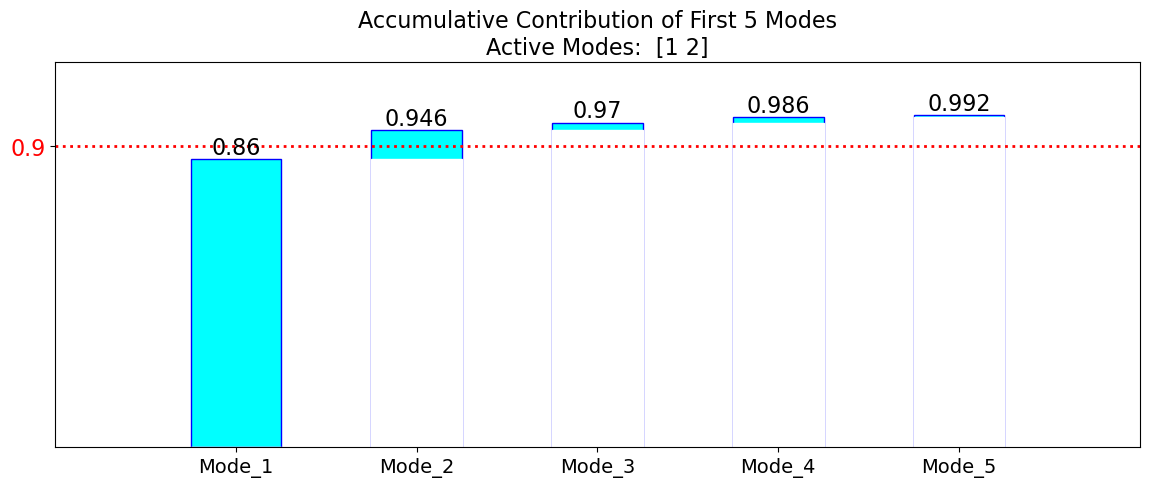

In [15]:
# (input) (optional)
nModes = 5    # number of modes to be plotted  

# (auto)
# define a function called Show_Contrib which plots accumulated contribution of modes
def Show_Contrib(nModes,nStory,CF):
    nModes = min(nModes,nStory)
    nModes = max(nModes,1)
    S = [ CF[0] ]
    for i in range(1,nStory): S.append( S[-1] + CF[i] )
    y0, y1 = S-CF, S
    x = np.arange(1,nModes+1)

    # reducing size of S
    S_new = [ S[0] ]
    for i in range(1,nModes): S_new.append(S[i])
    S = S_new.copy()


    fig, ax = plt.subplots( figsize=(14,5) )
    for i in range(0,nModes):
        plt.bar( [x[i],x[i]],[0,y1[i]], width=0.5, color='cyan',  edgecolor='blue' )
        plt.bar( [x[i],x[i]],[0,y0[i]], width=0.5, color='white', edgecolor='white')

    for i, val in enumerate( np.round(S,3) ):
        plt.text(i+1, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})

    ax.plot( [x[0]-1,x[-1]+1],[Modal_Contribution,Modal_Contribution], lw=2, c='red', ls=':')

    # Decoration
    plt.title( 'Accumulative Contribution of First '+str(nModes)+' Modes'
              +'\nActive Modes:  '+str(Important_Modes),fontsize=16)

    xtick_labels=[]
    for i in range(1,nModes+1):
        xtick_labels.append('Mode_'+str(i))
    ax.set_xticks( np.arange(1,nModes+1) ) 
    ax.set_xticklabels( xtick_labels )
    plt.xticks(rotation=0,fontsize=14)
    plt.xlim(x[0]-1,x[-1]+1) 

    ytick_labels=[str(Modal_Contribution)] 
    ax.set_yticks( [Modal_Contribution] ) 
    ax.set_yticklabels( ytick_labels )
    plt.yticks(rotation=0,fontsize=16,color='red')
    plt.ylim(0,1.15) 

    plt.show()
    
    return None

Show_Contrib(nModes,nStory,CF)

#####   
### Reading the Ground-Acceleration Time-History

In [16]:
# (input) Time-History & dt & rD (damping-ratio)

Time_History = pd.read_csv('El_Centro_TH.csv',header=2)

dt = 0.02  # (second)
rD = 0.02  # damping ratio
g  = 9800  # mm/sec2 

Earth_Quake_Name = 'El_Centro'

print( Time_History.head(3) )

   El_Centro
0    0.00000
1    0.00630
2    0.00364


In [17]:
# (auto)  Completing Data 
Ag = g*Time_History.values
t  = np.array( Time_History.index*dt, 'float64' )
print(Earth_Quake_Name+' Earthquake\nTime = '+str(t[-1])+' (sec)')

El_Centro Earthquake
Time = 31.18 (sec)


#####  
### Visualizing the Ground Acceleration Time-History


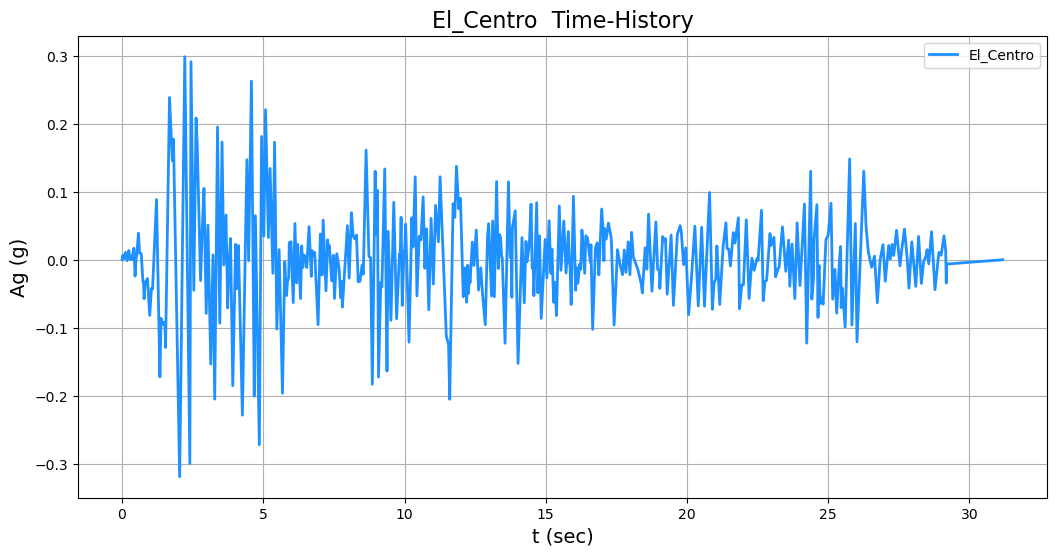

In [18]:
# (auto) plot  
fig,ax = plt.subplots( figsize=(12.5,6) )
### Time-History of Ground acceleration
ax.plot(  t, Ag/g, '-', color='dodgerblue', linewidth=2 )   
# Decoration
plt.title(Earth_Quake_Name+'  Time-History',fontsize=16)
plt.xlabel('t (sec)',fontsize=14)
plt.ylabel('Ag (g)',fontsize=14) 
plt.legend([ Earth_Quake_Name ])
plt.grid('on')
plt.savefig(Earth_Quake_Name+'_TH.png', dpi=120)   
plt.show()

#####  
### Solving The Differential Equation of Motion
### u"  +  2.rD.wn.u' + wn^2.u = -Ag    
 - u:displacement   v:velocity  a:acceleration
 - y = [u, v]            
 - du/dt = v
 - dv/dt = a  = -2.rD.wn.u' - wn^2.u - Ag
   

In [19]:
# (auto)
# define a function that solves the Earthquake Differential Equation of Motion:
#
#                     u" + 2.rD.wn.u' + wn**2.u = -Ag
#                 
# for known:
#    damping ratio, rD 
#    natural period, Tn
#    ground-acceleration time-history, Ag(t)
#
# and returns a dataframe ( uva ) containing:
#   displacements, u(t)
#   velocity, v(t) 
#   total acceleration,   a_total(t)   =  (-wn**2)*u(t) + (-2*rD*wn)*v(t)  
#   pseudo acceleration,  a_pseudo(t)  =  (-wn**2)*u(t) 

  
def find_uva(rD,Tn,Ag):
    wn = 2*np.pi/Tn 
    u_All, v_All, a_total_All, a_pseudo_All = [],[],[],[] 
    
    # coeffs:   b:-2*rD*wn  c:-wn**2 
    b, c = -2*rD*wn, -wn**2 
    # Initial displacement & velocity  @  t=0
    u0, v0 = 0, 0        
    y0 = [ u0, v0 ]
    
    for ag in -Ag:  #Time_History['El_Centro'].values: 
        # define  dy/dt  
        def dydt(t, y):
            """ Return dx/dt = f(t, x) at time t. """
            u, v  = y 
            dudt  = v
            dvdt  = b*v + c*u + ag 
            return dudt , dvdt
        
        # Integrate the differential equation.
        soln = solve_ivp(  dydt,  (0,dt),  y0,  dense_output=True,  method='RK45'  )
        
        t = np.linspace( 0,dt, 2 )
        u, v = soln.sol(t)  
        a_total  = +b*v + c*u
        a_pseudo = +c*u
        
        # Initial displacement & velocity  
        u0, v0 = u[-1], v[-1]        
        y0 = [ u0, v0 ] 
        
        # appending
        u_All.append(u)
        v_All.append(v) 
        a_total_All.append(a_total)
        a_pseudo_All.append(a_pseudo)
        
        # uva DataFrame
        Dict={  'u' : np.array(u_All).T[1]
              , 'v' : np.array(v_All).T[1] 
              , 'a_total'  : np.array(a_total_All).T[1]
              , 'a_pseudo' : np.array(a_pseudo_All).T[1] } 
        columns = Dict.keys()
        uva = pd.DataFrame(data=Dict,columns=columns)
        
    return uva

##### 
### pseudo acceleration


In [20]:
# (auto) 
# define a function called uvaModes that solves differential equation for importants Modes 
# and returns u(t), v(t) & a_ps(t) for those Modes

def uvaModes(rD,wfT,Ag,Important_Modes):
    
    Tn = wfT['Tn'].copy()
    Tn.index = np.arange(1,len(Tn)+1)
    Tn_Range = Tn[ Important_Modes ]
    
    m = len(Ag)
    n = len(Important_Modes)
    
    uModes=np.zeros([m,n],'float64')       
    uModes=pd.DataFrame(uModes,columns=Important_Modes.astype(int).astype(str))
    vModes=np.zeros([m,n],'float64')
    vModes=pd.DataFrame(vModes,columns=Important_Modes.astype(int).astype(str))
    a_psModes=np.zeros([m,n],'float64')
    a_psModes=pd.DataFrame(a_psModes,columns=Important_Modes.astype(int).astype(str))   
    
    j = 1.0; COLS=[]
    for Tn in Tn_Range:
        uva = find_uva(rD,Tn,Ag)
        print('\n\nTn =',Tn)
        print(uva.head(3))
        uModes[ str(int(j)) ] = uva['u']
        vModes[ str(int(j)) ] = uva['v']
        a_psModes[ str(int(j)) ] = uva['a_pseudo']
        COLS.append( 'Mode_'+str(int(j)) )
        j = j+1
    uModes.columns, vModes.columns, a_psModes.columns = COLS, COLS, COLS
    return [uModes,vModes,a_psModes]
        
print( 'Active Modes: '+str(Important_Modes) )
[uModes,vModes,a_psModes] = uvaModes(rD,wfT,Ag,Important_Modes) 

Active Modes: [1 2]


Tn = 1.43
          u         v   a_total  a_pseudo
0  0.000000  0.000000 -0.000000 -0.000000
1 -0.012326 -1.231046  0.454316  0.237956
2 -0.043946 -1.928514  1.187349  0.848406


Tn = 0.48
          u         v   a_total  a_pseudo
0  0.000000  0.000000 -0.000000 -0.000000
1 -0.012235 -1.214373  2.732268  2.096424
2 -0.042774 -1.821035  8.282747  7.329255


##### 
### Dynamic Responses

In [21]:
# Global Responses:  R (R:Response)  ---  Rs Rb (s:story b:base)

# define a function called R_maker that returns all Global Responses

def R_Maker(nStory,Ag,Important_Modes,a_psModes,us_st,vs_st,vb_st,ms_st,mb_st,fs_st):
    
    # empty R 
    Us = np.zeros([nStory,len(Ag)],'float64')    
    Vs = np.zeros([nStory,len(Ag)],'float64') 
    Vb = np.zeros([   1,  len(Ag)],'float64')    
    Ms = np.zeros([nStory,len(Ag)],'float64')
    Mb = np.zeros([   1,  len(Ag)],'float64')   
    Fs = np.zeros([nStory,len(Ag)],'float64')
    
    for Mode in Important_Modes:
    
        n = Mode-1   # strating from 0
    
        def dummy_adder( A, Mode ):
            B = np.zeros( [A.shape[0],2], 'float64' )
            B[:,0] = A.iloc[:,Mode].copy()
            return B

        Us = Us + dummy_adder( us_st, n ) @ dummy_adder( a_psModes, n ).T
        Vs = Vs + dummy_adder( vs_st, n ) @ dummy_adder( a_psModes, n ).T
        Vb = Vb + dummy_adder( vb_st, n ) @ dummy_adder( a_psModes, n ).T
        Ms = Ms + dummy_adder( ms_st, n ) @ dummy_adder( a_psModes, n ).T 
        Mb = Mb + dummy_adder( mb_st, n ) @ dummy_adder( a_psModes, n ).T
        Fs = Fs + dummy_adder( fs_st, n ) @ dummy_adder( a_psModes, n ).T
                
    return [Us,Vs,Vb,Ms,Mb,Fs]


[Us,Vs,Vb,Ms,Mb,Fs] = R_Maker(nStory,Ag,Important_Modes,a_psModes,us_st,vs_st,vb_st,ms_st,mb_st,fs_st)
print('Dynamic Responses of Active Modes are Generated.\n')

Dynamic Responses of Active Modes are Generated.



##### 
### Dynamic Responses Amplitude

In [22]:
# define a function called Dyn_Amp that returns Amplitude of Dynamic Responses for each Story

def Find_Dyn_Amps( nStory, Fs,Us,Vb,Vs,Mb,Ms, Mdyn, g ):
    
    # Force
    F_max=[0] # base_floor
    for i in range(0,nStory):
        MAX = np.max(abs(Fs[i]))
        F_max.append(int(np.round(MAX,0))) 

    # Displacement
    U_max=[0] # base_floor
    for i in range(0,nStory):
        MAX = np.max(abs(Us[i]))
        U_max.append( np.round(MAX,2)) 
    
    # Relative_Displacement
    U_rel_max = [ U_max[0] ]  # base_floor
    for i in range(1,nStory+1):
        rel = U_max[i] - U_max[i-1]
        U_rel_max.append( np.round(rel,3) )
    
    # Shear
    Vb_max = np.max(abs(Vb)) 
    V_max=[ int(np.round(Vb_max,0)) ]       # base_floor
    for i in range(0,nStory):
        MAX = np.max(abs(Vs[i]))
        V_max.append(int(np.round(MAX,0))) 
    
    # Moment
    Mb_max = np.max(abs(Mb)) 
    M_max=[ int(np.round(Mb_max,0)) ]       # base_floor
    for i in range(0,nStory):
        MAX = np.max(abs(Ms[i]))
        M_max.append(int(np.round(MAX,0)))  

    # Stiffness
    K = [0]   # base_floor
    for i in range(1,nStory+1):
        Story_Stiffness = F_max[i] / U_rel_max[i]
        K.append( np.round(Story_Stiffness,3) )
    
    # Mass
    M = [0]  # base_floor
    for i in range(0,nStory):
        M.append( np.diag(Mdyn)[i] )
    
    # Acceleration
    A_max = [0] # base_floor
    for i in range(1,nStory+1):
        Story_Acceleration = F_max[i] / M[i] / g
        A_max.append( np.round(Story_Acceleration,3) ) 

    
    Dict = { 'F_max'           : F_max
           , 'Story_Stiffness' : K
           , 'Story_Mass'      : M
           , 'U_max'           : U_max
           , 'U_rel_max'       : U_rel_max
           , 'Accel_max'       : A_max
           , 'V_max'           : V_max
           , 'M_max'           : M_max }


    Indx = ['Base_Floor']
    for i in range(1,nStory): Indx.append( 'Story_'+str(i) )
    Indx.append('Roof')
    Dyn_Amps = pd.DataFrame( data=Dict, columns=Dict.keys(), index=Indx )
    
    return Dyn_Amps
    
Dyn_Amps = Find_Dyn_Amps( nStory, Fs,Us,Vb,Vs,Mb,Ms, Mdyn, g )

##### 
# Results
#####   

### Modal Analysis Reslults

In [23]:
# (auto)
Modes = [1,2,3,4,5,6,7]
Modes = list(np.array(Modes)-1)

print('\nActive Modes =', Important_Modes)

# (auto) w f T CF
wfT.iloc[ Modes, : ].style.\
bar(subset=['wn'], color='dodgerblue').\
bar(subset=['fn'], color='cyan').\
bar(subset=['Tn'], color='yellow').\
bar(subset=['CF'], color='lime').\
bar(subset=['CF_Sum'], color='deeppink').\
format(precision=3) 


Active Modes = [1 2]


,wn,fn,Tn,CF,CF_Sum
Mode_1,4.400,0.700,1.430,0.860,0.860
Mode_2,13.200,2.100,0.480,0.087,0.946
Mode_3,21.960,3.490,0.290,0.024,0.970
Mode_4,30.660,4.880,0.200,0.016,0.986
Mode_5,39.210,6.240,0.160,0.006,0.992
Mode_6,47.430,7.550,0.130,0.002,0.994
Mode_7,55.970,8.910,0.110,0.003,0.997


#####   

In [24]:
# (auto) ModeShapes
df  = Mode_Shapes.copy()
Asc = True
if df['Mode_1'].sum()>0: Asc=False
df = df.sort_values(['Mode_1'],ascending=[Asc])

df.iloc[ :, Modes ].style.\
bar(subset=['Mode_1'], color='cyan').\
bar(subset=['Mode_2'], color='lime').\
bar(subset=['Mode_3'], color='orange').\
bar(subset=['Mode_4'], color='deeppink').\
bar(subset=['Mode_5'], color='red').\
bar(subset=['Mode_6'], color='yellow').\
bar(subset=['Mode_7'], color='salmon').\
format(precision=3) 

,Mode_1,Mode_2,Mode_3,Mode_4,Mode_5,Mode_6,Mode_7
Story_20,1.978,2.003,2.143,-1.714,-1.915,-2.167,-1.357
Story_19,1.967,1.899,1.835,-1.235,-1.039,-0.717,-0.093
Story_18,1.944,1.697,1.265,-0.410,0.312,1.213,1.258
Story_17,1.910,1.407,0.513,0.529,1.521,2.331,1.437
Story_16,1.865,1.043,-0.312,1.320,2.034,1.890,0.277
Story_15,1.809,0.626,-1.093,1.742,1.617,0.184,-1.141
Story_14,1.743,0.176,-1.717,1.678,0.461,-1.645,-1.496
Story_13,1.705,-0.052,-1.905,1.413,-0.218,-2.007,-0.980
Story_12,1.619,-0.508,-2.009,0.484,-1.485,-1.392,0.972
Story_11,1.523,-0.938,-1.825,-0.580,-2.073,0.154,2.019


#####   
## Time-History Analysis Reslults

In [25]:
''' Dynamic Results '''
df  = Dyn_Amps.copy()

# reversing the index
Idx       = df.index
index_rev = list(reversed(Idx)) 
df        = df.loc[index_rev,:]

df.style.\
bar(subset=['F_max'], color='red').\
bar(subset=['Story_Stiffness'], color='magenta').\
bar(subset=['Story_Mass'], color='gray').\
bar(subset=['U_max'], color='cyan').\
bar(subset=['U_rel_max'], color='dodgerblue').\
bar(subset=['Accel_max'], color='deeppink').\
bar(subset=['V_max'], color='lime').\
bar(subset=['M_max'], color='orange').\
format(precision=3) 

,F_max,Story_Stiffness,Story_Mass,U_max,U_rel_max,Accel_max,V_max,M_max
Roof,146,80.220,0.024,144.010,1.820,0.624,146,0
Story_19,141,39.385,0.024,142.190,3.580,0.603,287,467387
Story_18,131,25.144,0.024,138.610,5.210,0.560,419,1386300
Story_17,118,17.665,0.024,133.400,6.680,0.504,536,2725788
Story_16,100,12.626,0.024,126.720,7.920,0.427,636,4441320
Story_15,80,15.326,0.024,118.800,5.220,0.342,716,6476954
Story_14,58,32.222,0.024,113.580,1.800,0.248,774,8768042
Story_13,53,13.947,0.024,111.780,3.800,0.226,820,11244347
Story_12,58,12.832,0.024,107.980,4.520,0.248,844,13869892
Story_11,71,13.447,0.024,103.460,5.280,0.303,846,16571696


##### 

##### 